# Кластеризация компаний

### Введение

Нашу работу с данными можно структурировать следующим образом:
1. Мы начнем с небольшой предобработки данных и EDA: посмотрим на данные, найдем категориальные переменные, посмотрим, какие из них могут иметь влияние на разделение компаний на кластеры, а какие – нет (их мы удалим). Переведем оставшиеся категориальные переменные переведем в формат чисел, чтобы иметь возможность использовать эти признаки для кластеризации
2. Затем при помощи the elbow method посмотрим, какое число кластеров должно быть оптимальным
3. Приступим непосредственно к кластеризации при помощи агломеративной иерархической кластеризации, а также попробуем описать кластеры различными стратегиями роста
4. Проведем кластеризацию при помощи метода K-Means и снова попробуем описать кластеры различными стратегиями роста
5. Наконец, мы посмотрим на результаты работы моделей и сравним их

### Шаг 0. Импорт библиотек и загрузка датасета

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

Загрузим датасет: https://www.kaggle.com/datasets/joshuapaulbarnard/inc-5000s-fastest-growing-companies-from-20072019/data

In [2]:
data = pd.read_csv('inc5000_12years.csv', encoding = 'unicode_escape')

In [3]:
data.head(10)

,year,rank,city,growth,workers,company,state_s,state_l,revenue,yrs_on_list,industry,metro
0,2019,1,Phoenix,36680.3882,40.0,Freestar,AZ,Arizona,36900000,1,Advertising & Marketing,Phoenix
1,2019,2,Brentwood,30547.9317,39.0,FreightWise,TN,Tennessee,33600000,1,Logistics & Transportation,Nashville
2,2019,3,Austin,23880.4852,190.0,Cece's Veggie Co.,TX,Texas,24900000,1,Food & Beverage,Austin
3,2019,4,Albuquerque,21849.8925,57.0,LadyBoss,NM,New Mexico,32400000,1,Consumer Products & Services,NaN
4,2019,5,Philadelphia,18166.4070,25.0,Perpay,PA,Pennsylvania,22500000,1,Retail,Philadelphia
5,2019,6,Miami,14183.4118,742.0,Cano Health,FL,Florida,271800000,1,Health,Miami
6,2019,7,Hoboken,13480.7310,12.0,Bear Mattress,NJ,New Jersey,20500000,1,Consumer Products & Services,New York City
7,2019,8,Mechanicsville,12700.6588,72.0,Connected Solutions Group,VA,Virginia,23300000,1,Telecommunications,"Richmond, VA"
8,2019,9,Cleveland,12564.5364,60.0,Providence Healthcare Management,OH,Ohio,225900000,1,Health,Cleveland
9,2019,10,Los Angeles,11996.2964,37.0,NOM,CA,California,21400000,1,Advertising & Marketing,Los Angeles


### Шаг 1. Работа с данными

Итак, у нас есть датасет, где хранятся данные о компаниях, которые попадали в список Inc 5000s Fastest Growing Companies за 2007-2019 годы. Для начала посмотрим на эти данные: увидим, сколько в них пропусков, есть ли дубликаты, проверим, какие признаки нам будут важны, а какие можно удалить

In [4]:
# смотрим, есть ли NaN, типы данных, признаки...
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60209 entries, 0 to 60208
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         60209 non-null  int64  
 1   rank         60209 non-null  int64  
 2   city         60208 non-null  object 
 3   growth       60205 non-null  float64
 4   workers      60203 non-null  float64
 5   company      60209 non-null  object 
 6   state_s      60208 non-null  object 
 7   state_l      60208 non-null  object 
 8   revenue      60208 non-null  object 
 9   yrs_on_list  60209 non-null  int64  
 10  industry     60177 non-null  object 
 11  metro        58614 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 5.5+ MB


Так как мы будем выделять стратегии роста компаний, будет логично, если каждая компания будет учитываться лишь один раз. так как в датасете данные за последние 5 лет, компании там могут повторяться, поэтому мы будем учитывать
наиболее актуальный результат: когда компания в последний раз попадала в список.

In [5]:
data = data.sort_values(by = "year", ascending = False)
print(len(data["company"].unique()))

23946


Получилось, что у нас не так много не повторяющихся данных. Однако если мы будем учитывать каждую компанию несколько раз, то мы можем разнести их по разным кластерам, хотя по сути это будет одна и та же компания. Поэтому несмотря на это, оставим только последнее вхождение компании в список

In [6]:
data = data.drop_duplicates(subset = "company")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23946 entries, 0 to 58607
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         23946 non-null  int64  
 1   rank         23946 non-null  int64  
 2   city         23945 non-null  object 
 3   growth       23943 non-null  float64
 4   workers      23945 non-null  float64
 5   company      23946 non-null  object 
 6   state_s      23945 non-null  object 
 7   state_l      23945 non-null  object 
 8   revenue      23946 non-null  object 
 9   yrs_on_list  23946 non-null  int64  
 10  industry     23940 non-null  object 
 11  metro        22738 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 2.4+ MB


Теперь заметим, что у нас есть сразу несколько колонок, которые отвечают за местонахождение компании: "state_s", "state_l", "metro", "city". Учитывая, что в колонке "metro" много пропусков, а город – очень конкретное местоположение (ниже показано, что уникальных значений почти 3500, причем больше 400 компаний находится лишь в 3 городах), а потому этот признак не будет иметь большое значение при выделении кластеров, оставим лишь название штата. Для удобства возьмем колонку с коротким названием – "state_s"

In [7]:
data["city"].value_counts()

New York          726
Chicago           455
Atlanta           411
Houston           388
Austin            371
                 ... 
Mebane              1
Greeneville         1
Downey              1
Columbia Falls      1
Wickliffe           1
Name: city, Length: 3469, dtype: int64

In [8]:
data = data.drop(['state_l', 'city', 'metro'], axis = 1)

Кроме того, колонки "year" и "yrs_on_list" тоже кажутся бесполезными при разделении данных на кластеры, ведь даже если компания много лет входит в список, ее стратегию роста нельзя определить однозначно: возможно, она стремится к увеличению показателя "growth", но она также может стремиться и к увеличению "revenue". Поэтому удалим эти 2 колонки. Также удалим колонки с названиями компаний – это своего рода идентификаторы каждой строки, так что они тоже будут бесполезны при кластеризации

In [9]:
data = data.drop(['year', 'yrs_on_list', 'company'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23946 entries, 0 to 58607
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rank      23946 non-null  int64  
 1   growth    23943 non-null  float64
 2   workers   23945 non-null  float64
 3   state_s   23945 non-null  object 
 4   revenue   23946 non-null  object 
 5   industry  23940 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.3+ MB


Видим, что осталось несколько пропусков в данных, но их не так много, поэтому можем их удалить. Кроме того, несмотря на то что в "revenue" нет значений NaN, тип данных стоит object. Заменим значения на int. А еще на всякий случай удалим строки, где "rank" принимает значения больше 5000 (ведь список каждый год на 5000 компаний) – вдруг такие есть?

In [10]:
data.dropna()
data.replace('#VALUE!', np.nan, inplace=True)
data.dropna(inplace=True)
data["revenue"] = data["revenue"].astype(int)
data["workers"] = data["workers"].astype(int) # а то будет еще нецелое число работников...
data = data[data["rank"] <= 5000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23863 entries, 0 to 58607
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rank      23863 non-null  int64  
 1   growth    23863 non-null  float64
 2   workers   23863 non-null  int64  
 3   state_s   23863 non-null  object 
 4   revenue   23863 non-null  int64  
 5   industry  23863 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.3+ MB


Заметим также, что у нас очень мало компаний с ростом больше 20000. Эти выбросы могут помешать дальнейшей работе алгоритмов, поэтому удалим эти компании: их не так много

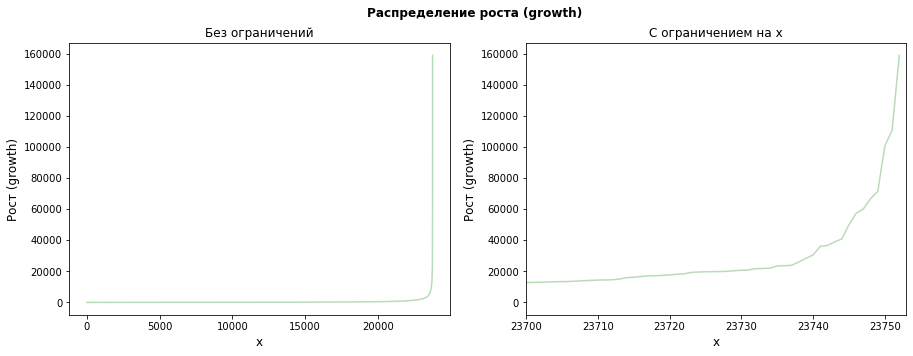

In [11]:
# хотим красивые цвета
sns.set_palette(palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])

plt.figure(figsize=[15, 5])
plt.suptitle("Распределение роста (growth)", weight = 'bold', fontsize = 12)

# график без ограничений
plt.subplot(1, 2, 1)
plt.plot([x for x in range(len(list(data["growth"].unique())))], sorted(list(data["growth"].unique())))
plt.title("Без ограничений", fontsize = 12)
plt.xlabel('x', fontsize = 12)
plt.ylabel('Рост (growth)', fontsize = 12)

# график с ограничением на x
plt.subplot(1, 2, 2)
plt.plot([x for x in range(len(list(data["growth"].unique())))], sorted(list(data["growth"].unique())))
plt.title("С ограничением на x", fontsize = 12)
plt.xlabel('x', fontsize = 12)
plt.ylabel('Рост (growth)', fontsize = 12)
plt.xlim(23700, len(list(data["growth"].unique())))

plt.show()

In [12]:
# убираем выбросы
data = data[data['growth'] <= 20000]

Аналогично поступим с выбросами в "revenue"

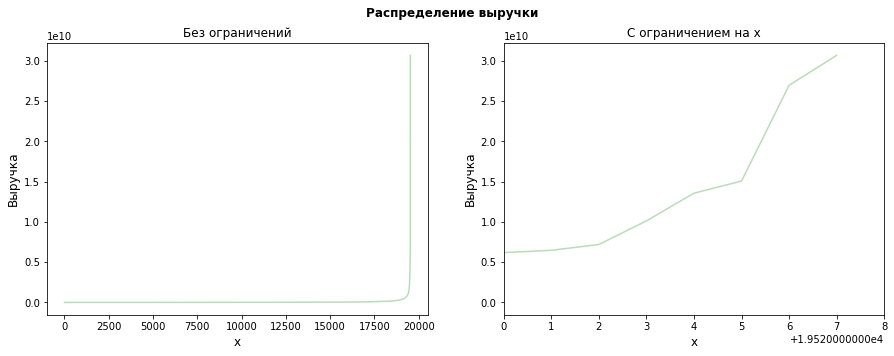

In [13]:
# опять хотим красивые цвета
sns.set_palette(palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])

plt.figure(figsize=[15, 5])
plt.suptitle("Распределение выручки", weight = 'bold', fontsize = 12)

# график без ограничений
plt.subplot(1, 2, 1)
plt.plot([x for x in range(len(list(data["revenue"].unique())))], sorted(list(data["revenue"].unique())))
plt.title("Без ограничений", fontsize = 12)
plt.xlabel('x', fontsize = 12)
plt.ylabel('Выручка', fontsize = 12)

# график с ограничением на x
plt.subplot(1, 2, 2)
plt.plot([x for x in range(len(list(data["revenue"].unique())))], sorted(list(data["revenue"].unique())))
plt.title("С ограничением на x", fontsize = 12)
plt.xlabel('x', fontsize = 12)
plt.ylabel('Выручка', fontsize = 12)
plt.xlim(19520, len(list(data["revenue"].unique())))

plt.show()

In [14]:
# убираем выбросы
data = data[data['revenue'] <= 1e10]

Супер! Теперь посмотрим на связь количественных переменных, а затем переведем категориальные признаки (у нас это "state_s" – штат и "industry" – сфера, в которой работает компания) в тип int

<AxesSubplot:>

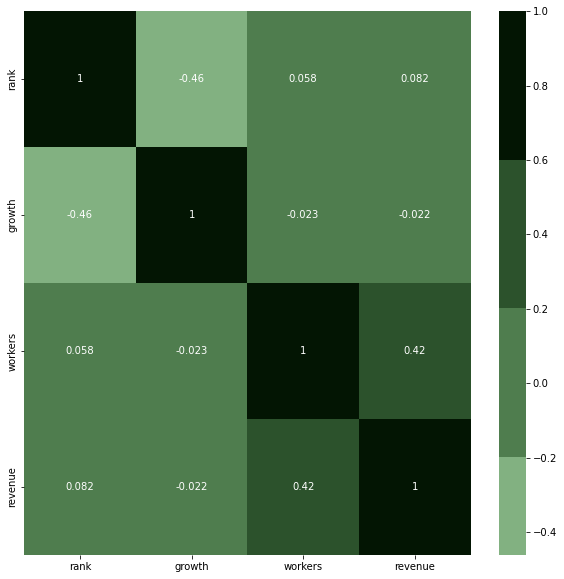

In [15]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot = True, cmap = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"], center = 0)

In [16]:
# сделаем label encoding: вместо категории в колонках теперь будет отражаться число.
# соответственно, мы как будто помечаем каждую уникальную категорию (штат / индустрию) числом
# и вместо строки кладем в датасет это число
OurLabelEncoder = LabelEncoder()
data[['state_s']] = data[['state_s']].apply(OurLabelEncoder.fit_transform)
data[['industry']] = data[['industry']].apply(OurLabelEncoder.fit_transform)
data

,rank,growth,workers,state_s,revenue,industry
3340,3332,107.5645,400,19,98900000,1
3347,3339,107.2731,55,34,5000000,9
3346,3338,107.3082,836,46,72800000,16
3345,3337,107.3476,33,41,18800000,26
3344,3336,107.3775,150,27,29300000,21
...,...,...,...,...,...,...
60051,4464,44.7022,618,19,135136635,21
58040,33,2842.6199,957,36,155900000,6
59026,2027,176.4854,19,41,4425414,15
58680,1286,278.2460,50,10,4436027,0


И не забудем отнормировать (scale) данные: используемые нами алгоритмы машинного обучения считают расстояния между объектами или кластерами (о том, как именно, мы скажем чуть дальше), а потому данные нуждаются в нормировке. Действительно, если признаки останутся ненормированными, то тогда тот факт, что у выручки значения могут достигать нескольких миллионов, может помешать найти оптимальные кластеры: при подсчете расстояний, вернее, квадратов расстояний между векторами-объектами расстояние будет казаться модели значительным из-за того, что числа, соответствующие выручке, принимают большие значения, даже если разница между ними не такая большая, всего в несколько сотен долларов.

In [17]:
data2 = data.copy()
OurStandardScaler = StandardScaler()
OurStandardScaler.fit(data2)
scaled_data = pd.DataFrame(OurStandardScaler.transform(data2), columns = data2.columns)
scaled_data

,rank,growth,workers,state_s,revenue,industry
0,0.446925,-0.267430,0.125546,-0.291808,0.244026,-1.255966
1,0.451646,-0.267713,-0.121363,0.665159,-0.202389,-0.271164
2,0.450972,-0.267679,0.437581,1.430733,0.119943,0.590538
3,0.450297,-0.267640,-0.137108,1.111744,-0.136781,1.821541
4,0.449623,-0.267611,-0.053374,0.218574,-0.086863,1.206040
...,...,...,...,...,...,...
23828,1.210332,-0.328475,0.281563,-0.291808,0.416300,1.206040
23829,-1.777879,2.388589,0.524178,0.792755,0.515012,-0.640465
23830,-0.433150,-0.200500,-0.147128,1.111744,-0.205120,0.467438
23831,-0.932872,-0.101680,-0.124942,-0.865989,-0.205070,-1.379066


Теперь подумаем, какие признаки могут больше всего влиять на итоговый результат. Выдвинем гипотезу, что компании можно будет разделить на определенное количество групп в соответствии с их стратегиями роста следующим образом: некоторые компании больше сфокусированы непосредственно на росте компании за год ("growth"), другие же сфокусированы на том, чтобы достигнуть как можно большей выручки ("revenue"). Разница заключается в том, что если у компании 1 была выручка в 1000000 долларов в прошлом году, то чтобы вырасти в 2 раза, ей понадобится увеличить выручку до 2000000 долларов, в то время как компании 2 с выручкой в 100 долларов в прошлом году понадобится увеличить выручку лишь на 100 долларов, чтобы увеличить ее в 2 раза. Тогда "хорошим результатом", целью компания 1 может считать увеличение выручки на 500000 долларов, и для нее это будет важнее, чем увеличить growth, достигнув роста выручки в 2 раза (очевидно, что чем выше была выручка раньше, тем сложнее достигнуть более высокого показателя growth).\
\
Кроме того, возможно, компании стремятся попасть в список Inc (данные с которого мы используем), например, для того, чтобы стать известнее, ведь про некоторые компании из списка Inc публикует статьи. По этой причине этот признак может оказаться важным. Тут может возникнуть вопрос, почему мы оставляем этот признак, а не число работников компании, который тоже кажется важным. Однако если вернуться к корреляционной матрице, которую мы рисовали раннее, то можно заметить, что выручка, которую мы уже учитываем, сильно скоррелирована с числом работников, поэтому последний признак мы учитывать не будем (ведь он будет излишним из-за высокой корреляции с выручкой).\
\
Что касается оставшихся признаков – индустрии и штата, то они не так сильно могут влиять на стратегию роста компаний. Конечно, можно было бы выделить стратегии роста внутри группы сфер или объединить компании в зависимости местоположения, однако в таком случае было бы сложнее описать стратегии роста компаний, относящихся к найденным кластерам. Например, если окажется, что компании были разделены по группам в зависимости от штатов, то тогда мы бы вряд ли смогли сделать выводы о том, в чем заключается их стратегия. Для того чтобы результаты можно было проще интерпретировать, попробуем использовать только признаки "rank", "growth", "revenue", а после получения результатов посмотрим, есть ли какая-то связь между разделением компаний на кластеры и их распределением по штатам или сферам.

In [18]:
scaled_data = scaled_data.drop(columns = {'workers', 'state_s', 'industry'})

### Шаг 2. The elbow method

In [19]:
# но сначала избавимся от рандома, чтобы результат не менялся с каждым запуском ячеек
# (это будет важно для 2 модели)
# теперь все, что определялось бы рандомно, будет определяться фиксированно в зависимости от нашего seed
np.random.seed(27)

Воспользуемся the elbow method, чтобы определить оптимальное количество кластеров в нашем случае. Работает этот метод следующим образом: мы смотрим на зависимость между числом кластеров и суммой квадратов расстояния между объектами каждого кластера (точками) и центром кластера, который определяется как среднее всех объектов кластера. То есть если мы будем увеличивать число кластеров, то точки внутри кластера будут располагаться все ближе и ближе друг к другу, поэтому сумма квадратов расстояния между объектами каждого кластера и центром кластера будет падать. Однако с определенного момента скорость, с которой меняется сумма квадратов расстояния, начнет падать. Так, если мы, скажем, увеличим число кластеров с 2 до 3, то сумма квадратов расстояния упадет сильно, а при увеличении кластеров с 8 до 9 – гораздо меньше. Если построить график зависимости суммы квадратов расстояния от числа кластеров, можно заметить точку, в которой скорость падения суммы квадратов расстояния снизится. Приблизительно в этой точке и будет оптимальное число кластеров (если представить, что график – это рука, то оптимальная точка будет похожа на локоть – elbow, поэтому метод так и называется: мы как будто ищем "локоть" нашего графика)

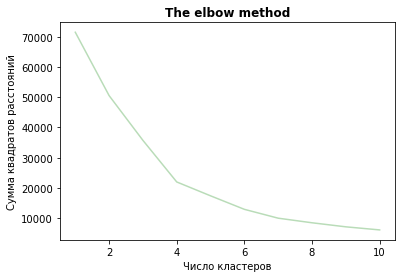

In [20]:
# тут будем хранить результаты суммы квадратов расстояния в зависимости от числа кластеров
extra_scaled_data = scaled_data.copy()
sum_square_distances = []
for i in range(1, 11):
    # пробуем разное число кластеров (подробнее о том, как работает сам метод kmeans, будет ниже)
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
    kmeans.fit(extra_scaled_data)
    # добавляем результат
    sum_square_distances.append(kmeans.inertia_)
plt.plot(range(1, 11), sum_square_distances)
plt.title('The elbow method', weight = 'bold', fontsize = 12)
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.show()

Так, видим, что наш график образует "локоть" в точке 4, поэтому попробуем значения 4, 5 в качестве оптимальных точек

### Шаг 3. Агломеративная иерархическая кластеризация

Простыми словами этот метод работает следующим образом: изначально у нас есть n кластеров, в каждом из которых содержится только одна точка, то есть каждый объект – это отдельный кластер. Далее на итерациях алгоритм объединяет 2 кластера в один, пока не достигнет желаемого количества кластеров.\
\
Как он их объединяет? В зависимости от расстояния между кластерами. За это в модели sklearn отвечают параметры metric – какую метрику расстояния выбрать (мы будем использовать ту, что идет по умолчанию, – евклидово расстояние, то есть расстояние $d(a, b) = \sqrt{\sum_{i = 1}^{n}(a_{i} - b_{i})^{2}}$, где a и b – векторы в n-мерном пространстве, то есть наши объекты с n признаками), а также linkage – то, как именно выбираются оптимальные для объединения кластеры: например, в зависимости от среднего / минимального / максимального расстояния между двумя объектами (то есть сначала у нас есть 2 кластера, и мы сравниваем расстояния между каждой парой точек, одна из которых находится в первом кластере, а другая во втором, после чего ищем среднее / минимальное / максимальное и стараемся минимизировать это расстояние). Мы выбрали значение по умолчанию ward, поскольку оно показывало результат, который можно интерпретировать как стратегии роста. Здесь кластеры объединяются следующим образом: для каждого кластера мы считаем его центр (среднее объектов кластера), а затем считаем сумму квадратов расстояния от каждого объекта выбранного кластера до центра кластера – пусть для 2 кластеров она равна k и l соответственно. После этого мы считаем, что произойдет, если мы объединим 2 кластера: аналогично считаем центр и сумму квадратов расстояния от каждого объекта нового кластера, состоящего из двух старых, до центра этого кластера – пусть она равна m. Объединяются те 2 кластера, у которых разница между m и k + l будет минимальна

In [21]:
# берем модель и число кластеров 4
agl_hier_cl = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
our_clusters = agl_hier_cl.fit_predict(scaled_data)
# добавляем колонку в данные, чтобы сделать графики
data["clusters"]= our_clusters

Смотрим, что получилось:

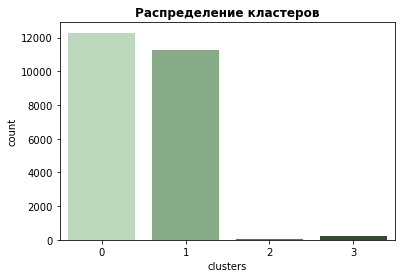

In [22]:
pl = sns.countplot(x = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
pl.set_title("Распределение кластеров", weight = 'bold', fontsize = 12)
plt.show()

Видим, что распределение кластеров не равномерное: в предпоследнем кластере объектов настолько мало, что их почти не видно. Попробуем посмотреть на то, как распределились кластеры, в осях признаков

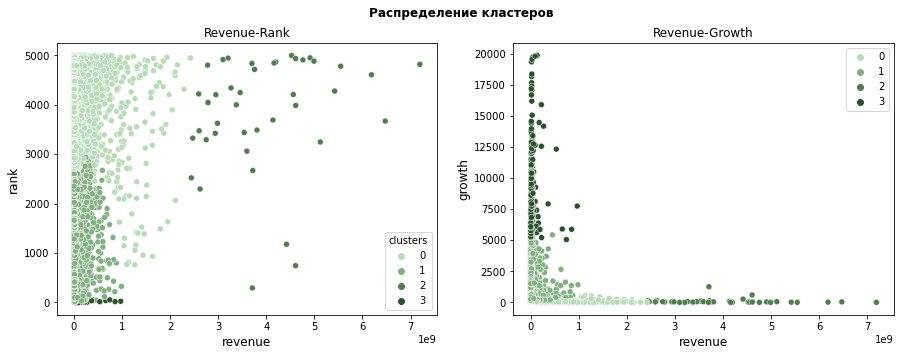

In [23]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график revenue-rank
plt.subplot(1, 2, 1)
plot1 = sns.scatterplot(x = data["revenue"], y = data["rank"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Revenue-Rank", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('rank', fontsize = 12)

# график revenue-growth
plt.subplot(1, 2, 2)
plot2 = sns.scatterplot(x = data["revenue"], y = data["growth"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Revenue-Growth", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

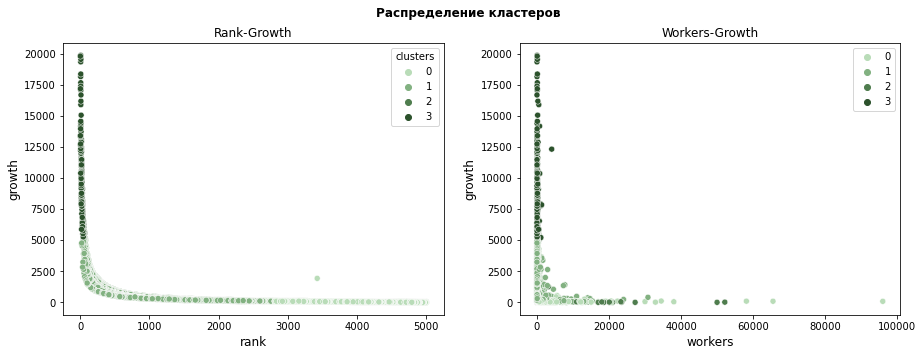

In [24]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график rank-growth
plt.subplot(1, 2, 1)
plot3 = sns.scatterplot(x = data["rank"], y = data["growth"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Rank-Growth", fontsize = 12)
plt.xlabel('rank', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

# график workers-growth
plt.subplot(1, 2, 2)
plot4 = sns.scatterplot(x = data["workers"], y = data["growth"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Workers-Growth", fontsize = 12)
plt.xlabel('workers', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

Так, видим распределение, кластеры в основном поделились на такие группы: ориентир на высокий growth, ориентир на высокую выручку (правда кластер получился совсем маленьким), ориентир на умеренный growth, ориентир на умеренную выручку (то есть фирмы стараются увеличить свою выручку, но их результат не так хорош, как у других фирм).\
\
Теперь попробуем сделать 5 кластеров

In [25]:
# берем модель и число кластеров 5
agl_hier_cl = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')
our_clusters = agl_hier_cl.fit_predict(scaled_data)
data["clusters"]= our_clusters

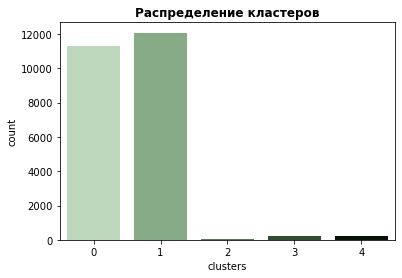

In [26]:
pl = sns.countplot(x = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
pl.set_title("Распределение кластеров", weight = 'bold', fontsize = 12)
plt.show()

Один из кластеров опять получился совсем маленького размера... И еще 2 тоже заметно меньше относительно первых двух. Посмотрим на распределение под другим углом, чтобы выделить стратегии роста

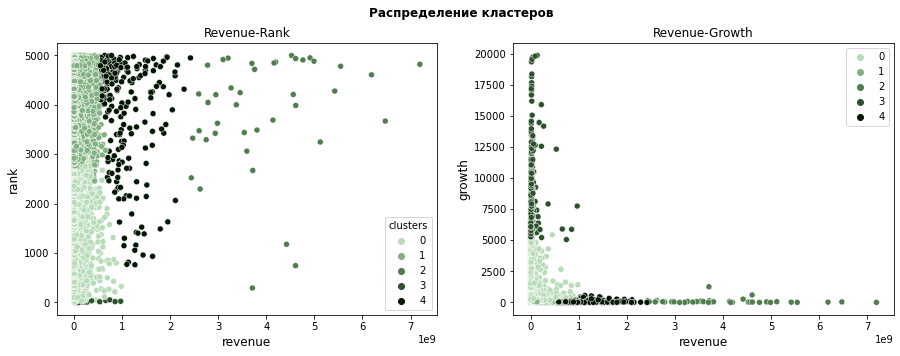

In [27]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график revenue-rank
plt.subplot(1, 2, 1)
plot1 = sns.scatterplot(x = data["revenue"], y = data["rank"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Revenue-Rank", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('rank', fontsize = 12)

# график revenue-growth
plt.subplot(1, 2, 2)
plot2 = sns.scatterplot(x = data["revenue"], y = data["growth"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Revenue-Growth", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

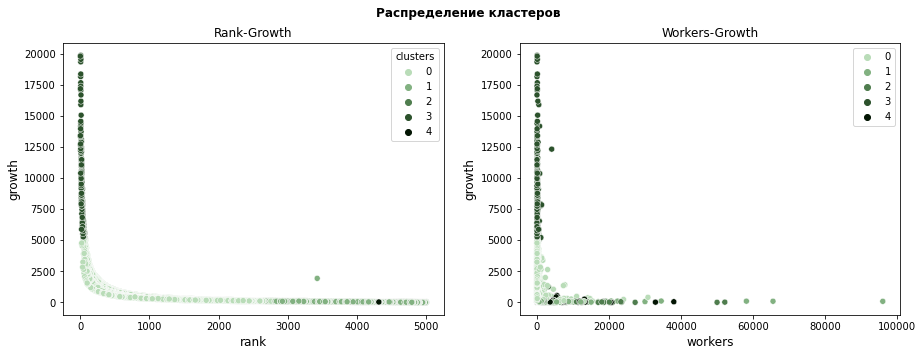

In [28]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график rank-growth
plt.subplot(1, 2, 1)
plot3 = sns.scatterplot(x = data["rank"], y = data["growth"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Rank-Growth", fontsize = 12)
plt.xlabel('rank', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

# график workers-growth
plt.subplot(1, 2, 2)
plot4 = sns.scatterplot(x = data["workers"], y = data["growth"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Workers-Growth", fontsize = 12)
plt.xlabel('workers', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

Графики не особо поменялись: просто выделился кластер тех, у кого относительно низкий и рост, и выручка (они находятся внизу рейтинга и имеют относительно небольшую выручку – это кластер 1). Те, кому не так важны эти факторы, вероятно, фокусируются на чем-то, что не отражено в датасете: добавлении новых продуктов или услуг, расширении компании (когда главный офис находится в одном городе или штате, а точки сети – по всей стране) или чем-то еще. Первые же 4 группы остались те же: ориентир на высокий growth, ориентир на высокую выручку (правда кластер получился совсем маленьким), ориентир на умеренный growth, ориентир на умеренную выручку (то есть фирмы стараются увеличить свою выручку, но их результат не так хорош, как у других фирм)\
\
Кроме того, если смотреть на распределение кластеров в зависимости от штата и индустрии, то можно заметить, что они распределились достаточно хаотично, чего и следовало ожидать, так как мы приняли решение не использовать эти признаки при кластеризации. Лишь в некоторых штатах (например, штатах, чей номер близок к 4 или 45) можно заметить тенденцию склонности к стратегии роста, которой соответствует кластер 0: эти компании находятся в первой половине рейтинга и больше фокусируются на growth, однако они не достигли достаточного уровня роста, чтобы быть в топе рейтинга (вероятно, потому что это и так достаточно крупные компании -> им сложнее совершить большой скачок)

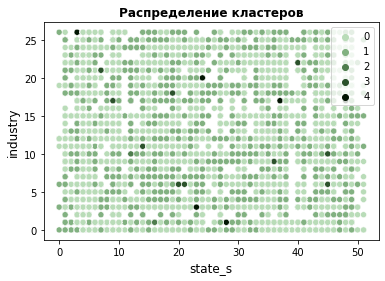

In [29]:
plot1 = sns.scatterplot(x = data["state_s"], y = data["industry"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plot1.set_title("Распределение кластеров", weight = 'bold', fontsize = 12)
plt.xlabel('state_s', fontsize = 12)
plt.ylabel('industry', fontsize = 12)
plt.legend()
plt.show()

### Шаг 4. K-means

Этот метод идейно отличается от предыдущего. Он заключается в следующем: пусть мы хотим получить n кластеров. Тогда сначала мы выбираем n центров для этих кластеров. Это можно делать по-разному, например, рандомно, однако такой способ может привести к тому, что изначальные центры попадут очень далеко от объектов выборки или окажутся слишком близко друг к другу. Поэтому мы будем использовать улучшение метода – k-means++, который помогает выбрать изначальные центры "по-умному". Первый центр выбирается случайно из наших объектов. Далее каждый центр мы выбираем так: сначала считаем квадрат расстояния от всех объектов до выбранных центров, а затем в качестве следующего центра выбираем случайно один из оставшихся, причем чем больше квадрат расстояния от i объекта до ближайшего центра, тем выше вероятность выбрать i объект как центр. По-простому, мы берем центр, который находится как можно дальше от уже выбранных центров, но все так же выбираем его из объектов выборки, чтобы избежать случаев, когда центры находятся слишком близко друг к другу или слишком далеко от объектов выборки. На самом деле используемая нами реализация алгоритма из sklearn имеет небольшую модификацию, улучшающую результат кластеризации, ее часто называют greedy k-means++: там все изначальные центры, кроме первого, выбираются несколько раз (так как несмотря на различные вероятности, выбор все равно происходит случайно, то есть мы не будем каждый раз выбирать центр с наибольшей вероятностью – вдруг это, скажем, окажется выброс, и центр будет слишком далеко от остальных объектов), после чего остается "оптимальный" центр, при котором сумма квадратов расстояний от объектов до ближайших центров будет минимальна.\
\
После того как мы выбрали изначальные центры, мы создаем первые кластеры: каждый объект помещаем в кластер с центром, который находится ближе всего к объекту. После получения наших n "первых" кластеров мы меняем положение центров, и теперь они не обязаны быть объектами нашей выборки. Каждый центр кластера i будет переопределяться как среднее всех объектов, которые мы отнесли к кластеру i. После вычисления новых центров мы снова создаем кластеры, каждый объект помещая в кластер с обновленным центром, находящимся ближе всего к объекту. Эти шаги мы будем повторять, пока центры не перестанут меняться.\
\
Итак, посмотрим на результаты, если мы берем 4 кластера, а затем 5, не забыв про улучшение k-means – k-means++.

In [30]:
# поделим на 4 кластера
OurKMeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
our_clusters2 = OurKMeans.fit_predict(scaled_data)
data["clusters2"]= our_clusters2

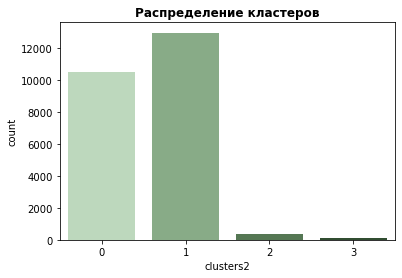

In [31]:
plot1 = sns.countplot(x = data["clusters2"])
plot1.set_title("Распределение кластеров", weight = 'bold', fontsize = 12)
plt.show()

Видим результат, очень похожий на тот, что мы видели в предыдущем шаге с агломеративной иерархической кластеризацией. Однако кажется, что здесь самый маленький кластер все же имеет чуть больше объектов. Несмотря на это, все еще видим два больших кластера и два маленьких вместо четырех приблизительно одинаковых групп. Посмотрим на то, как распределились кластеры, в осях признаков

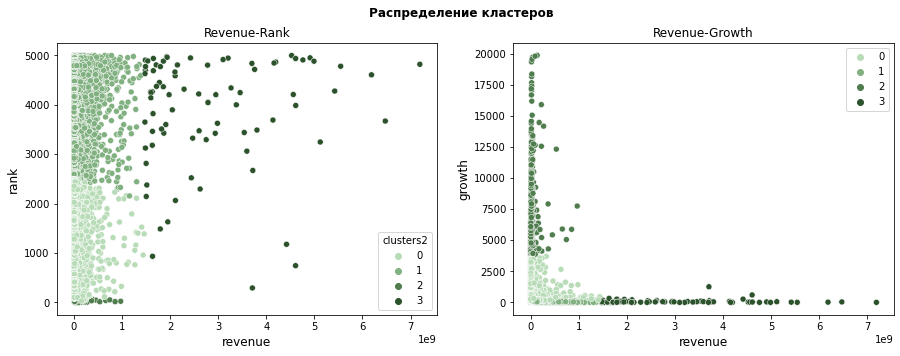

In [32]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график revenue-rank
plt.subplot(1, 2, 1)
plot1 = sns.scatterplot(x = data["revenue"], y = data["rank"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Revenue-Rank", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('rank', fontsize = 12)

# график revenue-growth
plt.subplot(1, 2, 2)
plot2 = sns.scatterplot(x = data["revenue"], y = data["growth"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Revenue-Growth", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

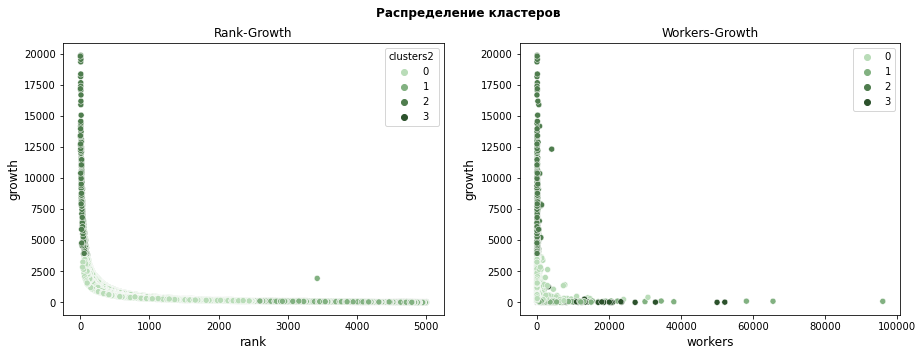

In [33]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график rank-growth
plt.subplot(1, 2, 1)
plot3 = sns.scatterplot(x = data["rank"], y = data["growth"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Rank-Growth", fontsize = 12)
plt.xlabel('rank', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

# график workers-growth
plt.subplot(1, 2, 2)
plot4 = sns.scatterplot(x = data["workers"], y = data["growth"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C"])
plt.title("Workers-Growth", fontsize = 12)
plt.xlabel('workers', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

Опять же, можно заметить, что результаты практически такие же, какие мы наблюдали ранее: компании с очень высоким показателем growth, компании с очень высоким показателем revenue, компании с более высоким показанием growth и низким revenue и компании с более высоким показателем revenue и низким growth. Тогда перейдем к случаю, когда мы выбираем 5 кластеров

In [34]:
# поделим на 5 кластеров
OurKMeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
our_clusters2 = OurKMeans.fit_predict(scaled_data)
data["clusters2"]= our_clusters2

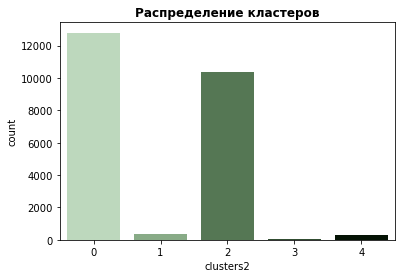

In [35]:
plot1 = sns.countplot(x = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plot1.set_title("Распределение кластеров", weight = 'bold', fontsize = 12)
plt.show()

Результат снова похож на то, что показала нам агломеративная иерархическая кластеризация. В этот раз 2 маленьких кластера (в k-means это кластеры 1 и 4), однако, получились немного больше, чем в шаге 3. Тем не менее мы вновь не получили кластеры с примерно одинаковым количеством компаний в каждом. Теперь снова посмотрим на распределение классов в различных осях признаков

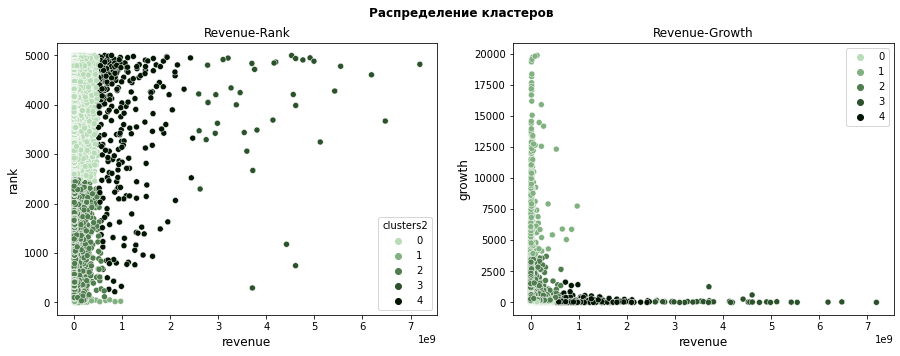

In [36]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график revenue-rank
plt.subplot(1, 2, 1)
plot1 = sns.scatterplot(x = data["revenue"], y = data["rank"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Revenue-Rank", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('rank', fontsize = 12)

# график revenue-growth
plt.subplot(1, 2, 2)
plot2 = sns.scatterplot(x = data["revenue"], y = data["growth"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Revenue-Growth", fontsize = 12)
plt.xlabel('revenue', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

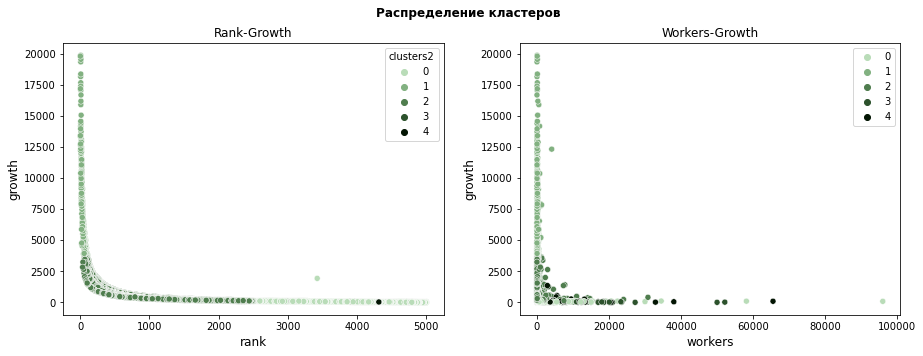

In [37]:
plt.figure(figsize=[15, 5])
plt.suptitle("Распределение кластеров", weight = 'bold', fontsize = 12)

# график rank-growth
plt.subplot(1, 2, 1)
plot3 = sns.scatterplot(x = data["rank"], y = data["growth"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Rank-Growth", fontsize = 12)
plt.xlabel('rank', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

# график workers-growth
plt.subplot(1, 2, 2)
plot4 = sns.scatterplot(x = data["workers"], y = data["growth"], hue = data["clusters2"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plt.title("Workers-Growth", fontsize = 12)
plt.xlabel('workers', fontsize = 12)
plt.ylabel('growth', fontsize = 12)

plt.legend()
plt.show()

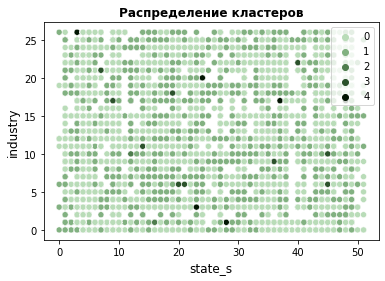

In [38]:
plot1 = sns.scatterplot(x = data["state_s"], y = data["industry"], hue = data["clusters"], palette = ["#B9DCB8", "#82B181", "#4F7D4E", "#2C522C", "#031503"])
plot1.set_title("Распределение кластеров", weight = 'bold', fontsize = 12)
plt.xlabel('state_s', fontsize = 12)
plt.ylabel('industry', fontsize = 12)
plt.legend()
plt.show()

Графики очень похожи на то, что мы видели ранее. По сравнению с 4 кластерами здесь снова добавился кластер, куда отнесены компании с относительно низким уровнем growth и revenue. Вероятно, их главной целью была работа над показателем, который не отражен в датасете: например, как мы писали ранее, это может быть количество продуктов или услуг в предлагаемой линейке, чтобы расширить целевую аудиторию, или доля на рынке продуктов (услуг), которые продают (оказывают) эти компании, что нельзя вычислить исходя из данных в датасете (например, нам не дан объем продаж каждой компании, по которому можно было бы посчитать долю на рынке Health, Retail, Advertising & Marketing и так далее). Зависимости между распределением по штатам и сферам с распределением по кластерам все так же не видны

### Выводы

Итак, мы посмотрели результаты нескольких моделей, используя агломеративную иерархическую кластеризацию и k-means (с улучшением, которое помогает лучше выбирать изначальные центры), а также меняя количество кластеров (однако оставляя это число близким к "оптимальному" – подобранному при помощи the elbow method). Несмотря на то что во всех случаях кластеры получились не совсем равномерными, мы можем выделить основные стратегии роста компаний:\
\
• Максимальный фокус на growth, то есть улучшении выручки за последние 3 года в процентах (именно это значит этот признак, источник: https://www.inc.com/inc5000/2023, последнее обращение 09.11.2023). Вероятнее всего, это относительно новые, не так давно существующие компании, возможно, стартапы, которым проще осуществить такой скачок, чем корпорациям, существующим уже много десятков лет\
\
• Основной фокус на growth, однако эти компании находятся ниже в рейтинге по сравнению с компаниями из предыдущего пункта. Можно предположить, что эти компании существуют дольше тех, что относятся к предыдущей группе, а потому не могут достигнуть такого большого увеличения выручки в процентах за последние 3 года. Тем не менее их стратегия роста, вероятно, тоже направлена не на достижение определенного уровня выручки (например, 100000000 долларов), а на увеличение growth, что можно также рассматривать как увеличение среднегодового роста (так как данные даны за 3 года, то средний рост за год будет равен $\frac{growth}{3}$, которому будет соответствовать высокое значение, так как у growth тоже будет высокое значение)\
\
• Максимальный фокус на выручке. Этим компаниям сложно достигнуть высокого увеличения выручки в процентах, поскольку их выручка 3 года назад, скорее всего, была достаточно большая, поэтому этим компаниям нет смысла ставить цели увеличить выручку на 100%, им достаточно продолжать расширяться (например, расширять штат сотрудников, ведь workers имеет большую корреляцию с revenue, уровень которой у этих компаний очень высокий -> наверняка у этих компаний много работников) и увеличивать выручку на меньший процент: если бы была возможность сравнить данные по growth не в процентах, а в долларах, то эти компании, вероятно, оказались бы в топе. Кроме того, возможно, эти компании являются компаниями класса люкс (что не отражено в датасете), а потому у них наблюдается такая высокая выручка\
\
• Основной фокус на выручке. Эти компании похожи на те, что относятся к предыдущей группе, но они не смогли достигнуть таких высоких результатов. Возможно, их цели также касались чего-то, что не отражено в датасете: например, они могли фокусироваться на росте компании за счет увеличения линейки предлагаемых продуктов или услуг\
\
• При добавлении 5 кластера выделяются компании, которые не достигли относительных высоких результатов ни в growth, ни в выручке по сравнению с остальными компаниями. Как уже было замечено, наверное, эти компании фокусируются на чем-то, что не отражено в датасете: добавлении новых продуктов или услуг, расширении компании или чем-то еще, и их стратегия роста заключается именно в этом\
\
Получается, компании могут фокусироваться на увеличении среднегодового роста или же увеличении выручки в процентах; на увеличении непосредственно выручки в долларах, имея цель достигнуть очень большого уровня выручки, даже если в процентах рост будет не так заметен (возможно, эти компании также фокусировались на расширении штата работников); или комбинировать эти цели, возможно, также делая фокус на чем-то, что не отражено в датасете: расширении линейки продуктов или услуг, расширении компании по стране или увеличении доли на рынке продуктов или услуг, которые эти компании производят или оказывают. В этом и заключаются основные стратегии роста, которые можно выявить при анализе данного датасета